# Packages

In [4]:
!pip install lime
# basic packages
from time import time

# basic data processing packages
import numpy as np
from numpy import random
import pandas as pd

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# machine learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os, json
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable

# LIME packages
import lime
from lime import lime_image



# Predefined functions

In [5]:
def single_img_plot(X,y=10):
#     X = np.reshape(X, (28,28))
    plt.imshow(X)
    plt.colorbar()
    plt.title('MNIST random check, label %d' %y)
    plt.show()

## Build simple neural network using pytorch on MNIST

In [6]:
# n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Use Pytorch data loader to load MNIST data

In [7]:
# download and transform train dataset

from torchvision import datasets, transforms
from torch.autograd import Variable

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_train,
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST(root = './', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size_test,
                                           shuffle=True)




### Data check plot

In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Output tensor size check: ', example_data.shape)

Output tensor size check:  torch.Size([64, 1, 28, 28])


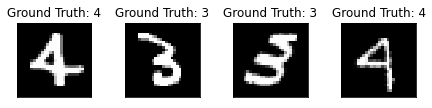

In [9]:
fig = plt.figure()
for i in range(4):
    idx_rand = random.randint(len(example_data))
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[idx_rand][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[idx_rand]))
    plt.xticks([])
    plt.yticks([])


### Build 2 CNN + 2 fully connected layer networks

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,-1)

In [64]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Train the model

In [65]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [71]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [72]:
n_epochs = 1
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [73]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3095, Accuracy: 1028/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320540
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.312641
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.288033
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.285810
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.266078
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.226933
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225379
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.210534
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.133121
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.096030
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.880780
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.967473
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.857093
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.736355
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.597949
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.413034
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.469076
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.376463
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.104833
Train Epoch: 1 [12160

### Performance check

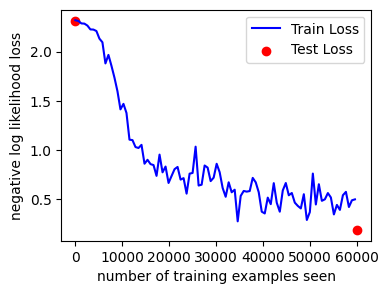

In [74]:
plt.figure(figsize = (4,3))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

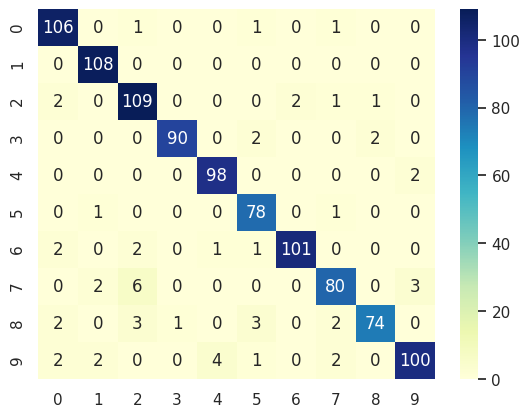

In [75]:
for data, target in test_loader:
      output = network(data)
output_idx = torch.argmax(output,dim=1)

cf_mat = confusion_matrix(target,output_idx)
sns.set(font_scale=1)
sns.heatmap(cf_mat,annot = True,cmap = 'YlGnBu', fmt='d', 
            xticklabels = np.arange(0,10), yticklabels = np.arange(0,10))

sns.reset_orig()

tensor([5, 4, 7, 3, 1, 5, 2, 6, 3, 4, 6, 2, 4, 3, 0, 1, 0, 2, 7, 1, 8, 1, 6, 7,
        4, 0, 7, 1, 7, 1, 6, 8, 2, 9, 9, 4, 6, 4, 5, 1, 8, 9, 8, 2, 1, 7, 4, 8,
        5, 3, 7, 4, 3, 6, 4, 7, 6, 5, 8, 4, 7, 7, 5, 4, 8, 9, 0, 8, 2, 2, 1, 2,
        4, 3, 8, 8, 7, 9, 8, 8, 1, 6, 3, 0, 6, 1, 4, 1, 3, 5, 1, 2, 5, 7, 5, 6,
        9, 6, 4, 3, 3, 2, 5, 2, 4, 6, 0, 2, 9, 1, 7, 1, 5, 2, 9, 2, 4, 7, 6, 7,
        3, 9, 2, 4, 4, 3, 3, 2, 2, 4, 0, 4, 9, 3, 0, 1, 6, 0, 4, 8, 0, 3, 0, 7,
        3, 2, 4, 5, 0, 4, 0, 2, 0, 4, 9, 1, 6, 2, 8, 7, 6, 4, 9, 5, 5, 3, 7, 9,
        3, 9, 0, 2, 1, 5, 7, 4, 1, 4, 8, 1, 1, 3, 7, 3, 8, 1, 4, 6, 5, 0, 6, 2,
        3, 1, 4, 0, 3, 5, 2, 3, 0, 4, 6, 8, 1, 0, 4, 2, 7, 8, 9, 8, 9, 9, 3, 6,
        0, 0, 1, 3, 9, 2, 9, 1, 9, 9, 3, 6, 7, 1, 1, 7, 1, 6, 7, 7, 6, 7, 8, 2,
        6, 1, 4, 0, 2, 0, 2, 0, 7, 5, 2, 0, 2, 2, 8, 2, 7, 4, 3, 8, 6, 4, 7, 2,
        9, 3, 7, 9, 3, 0, 2, 1, 1, 5, 8, 0, 1, 8, 6, 2, 2, 3, 1, 1, 2, 7, 4, 9,
        5, 9, 8, 1, 6, 6, 1, 5, 5, 1, 1,